In [266]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv
import time

In [267]:
# Initialize API Key from environment variables

load_dotenv()
API_KEY = os.getenv("GOOGLE_PLACES_API_KEY")


In [268]:
url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"

params = {
    "location": '39.335, -84.404',  # Hamilton, OH
    "radius": 3000,
    "type": "restaurant",
    "key": API_KEY
}

response = requests.get(url, params=params)
data = response.json()

print(data.keys())


dict_keys(['html_attributions', 'next_page_token', 'results', 'status'])


In [269]:
# Confirm that request was executed successfully
data['status']

'OK'

In [270]:
# Find out how many results exist and if there are multiple pages
print(len(data["results"]))
print("Has next page?", "next_page_token" in data)


20
Has next page? True


In [271]:
import json, os

# Save data to a JOSN file for caching
os.makedirs("cache", exist_ok=True)

with open("cache/page1.json", "w") as f:
    json.dump(data, f)


In [272]:
# -------------------------------
# Initialize storage and pagination state
# -------------------------------

# List to collect all place results across pages
all_results = []

# Page counter (Google Places Nearby Search returns up to 3 pages)
page = 1

# Token used to request the next page of results (None for first request)
token = None


# -------------------------------
# Paginated request loop
# -------------------------------

# Loop until there are no more pages or we reach the max page limit
while True:
    
    # If a next_page_token exists, request the next page
    if token:
        # Google requires a short delay before the token becomes valid
        time.sleep(2)
        params = {
            "pagetoken": token,
            "key": API_KEY
        }
    else:
        # First request: search for places near a specific location
        params = {
            "location": '39.335, -84.404',  # Downtown Hamilton, OH (lat, lng)
            "radius": 3000,                  # Search radius in meters
            "type": "restaurant",            # Place category
            "key": API_KEY
        }

    # Send request to the Places API and parse the JSON response
    data = requests.get(url, params=params).json()
    print("status:", data["status"])

    # Stop execution if the API returns an error
    if data["status"] != "OK":
        print("error:", data.get("error_message"))
        break
    
    # Append the current page of results to the master list
    all_results.extend(data["results"])

    # Retrieve token for the next page (if available)
    token = data.get("next_page_token")
    page += 1

    # Google Places Nearby Search supports a maximum of 3 pages
    if not token or page > 3:
        break


# -------------------------------
# Final result summary
# -------------------------------

# Print total number of places collected
print("Total places:", len(all_results))


status: OK
status: OK
status: OK
Total places: 60


In [273]:
# Save data to a pandas data frame and then csv file
df = pd.json_normalize(all_results)
df.to_csv("places_restaurants_WestchesterOH.csv", index=False)


In [274]:
# Read data from csv to a dataframe and view top 5 rows
data = pd.read_csv('places_restaurants_WestchesterOH.csv')
data.head()

,business_status,icon,icon_background_color,icon_mask_base_uri,international_phone_number,name,photos,place_id,price_level,rating,...,vicinity,geometry.location.lat,geometry.location.lng,geometry.viewport.northeast.lat,geometry.viewport.northeast.lng,geometry.viewport.southwest.lat,geometry.viewport.southwest.lng,opening_hours.open_now,plus_code.compound_code,plus_code.global_code
0,OPERATIONAL,https://maps.gstatic.com/mapfiles/place_api/ic...,#FF9E67,https://maps.gstatic.com/mapfiles/place_api/ic...,+1 513-860-5353,Jag's Steak & Seafood,"[{'height': 4000, 'html_attributions': ['<a hr...",ChIJQfeQ6jxQQIgRT9WQB0Nh3Kc,3.0,4.7,...,"5980 West Chester Road, West Chester Township",39.328929,-84.426382,39.330228,-84.424921,39.327530,-84.427619,False,"8HHF+HC Beckett Ridge, OH, USA",86FQ8HHF+HC
1,OPERATIONAL,https://maps.gstatic.com/mapfiles/place_api/ic...,#FF9E67,https://maps.gstatic.com/mapfiles/place_api/ic...,+1 513-779-3666,Little Caesars Pizza,"[{'height': 2448, 'html_attributions': ['<a hr...",ChIJhek3q4BQQIgRTLlTEftiYKw,1.0,3.5,...,"8231 Cincinnati Dayton Road SUITE 300, West Ch...",39.346658,-84.396215,39.348002,-84.394746,39.345304,-84.397443,True,"8JW3+MG Olde West Chester, OH, USA",86FQ8JW3+MG
2,OPERATIONAL,https://maps.gstatic.com/mapfiles/place_api/ic...,#FF9E67,https://maps.gstatic.com/mapfiles/place_api/ic...,+1 513-874-7468,Dingle House Irish Pub & Grub,"[{'height': 500, 'html_attributions': ['<a hre...",ChIJJyoVYiRQQIgRlQCxgZB4MPM,2.0,4.4,...,"9102 West Chester Towne Centre Road, West Ches...",39.326652,-84.430320,39.328046,-84.429093,39.325348,-84.431791,True,"8HG9+MV Beckett Ridge, OH, USA",86FQ8HG9+MV
3,OPERATIONAL,https://maps.gstatic.com/mapfiles/place_api/ic...,#FF9E67,https://maps.gstatic.com/mapfiles/place_api/ic...,+1 513-759-9398,Bravo! Italian Kitchen,"[{'height': 3036, 'html_attributions': ['<a hr...",ChIJy5SauTZQQIgRmJsfjl0lVr0,2.0,4.1,...,"9436 Water Front Drive, West Chester Township",39.318484,-84.422580,39.319858,-84.421044,39.317160,-84.423742,True,"8H9G+9X Beckett Ridge, OH, USA",86FQ8H9G+9X
4,OPERATIONAL,https://maps.gstatic.com/mapfiles/place_api/ic...,#FF9E67,https://maps.gstatic.com/mapfiles/place_api/ic...,+1 513-874-2521,Bob Evans,"[{'height': 3120, 'html_attributions': ['<a hr...",ChIJLXUusjpQQIgRjlVf_TFc1RY,2.0,4.2,...,"9223 Schulze Drive, West Chester Township",39.322983,-84.427618,39.324419,-84.426141,39.321721,-84.428839,True,"8HFC+5X Beckett Ridge, OH, USA",86FQ8HFC+5X


In [275]:
# Print a few columns
data[['name', 'international_phone_number', 'price_level', 'rating']].head()

,name,international_phone_number,price_level,rating
0,Jag's Steak & Seafood,+1 513-860-5353,3.0,4.7
1,Little Caesars Pizza,+1 513-779-3666,1.0,3.5
2,Dingle House Irish Pub & Grub,+1 513-874-7468,2.0,4.4
3,Bravo! Italian Kitchen,+1 513-759-9398,2.0,4.1
4,Bob Evans,+1 513-874-2521,2.0,4.2


In [276]:
# Define Downtown Hamiltons Coordinates, Same as for radius distance for restaraunts
DOWNTOWN_LAT = 39.335
DOWNTOWN_LNG = -84.404


In [277]:
# Create a function to calculate a restaraunts distance from downtown

import numpy as np

def haversine_km(lat1, lon1, lat2, lon2):
    """
    Calculate the great-circle distance between two points
    on the Earth (specified in decimal degrees).
    Returns distance in kilometers.
    """
    R = 6371  # Earth radius in kilometers

    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    return R * c


In [278]:
# Use Haversine function to calulate distances from downtown for each restaraunt in a new column
df["distance_to_downtown_km"] = haversine_km(
    DOWNTOWN_LAT,
    DOWNTOWN_LNG,
    df["geometry.location.lat"],
    df["geometry.location.lng"]
)

In [279]:
df.columns

Index(['business_status', 'icon', 'icon_background_color',
       'icon_mask_base_uri', 'international_phone_number', 'name', 'photos',
       'place_id', 'price_level', 'rating', 'reference', 'scope', 'types',
       'user_ratings_total', 'vicinity', 'geometry.location.lat',
       'geometry.location.lng', 'geometry.viewport.northeast.lat',
       'geometry.viewport.northeast.lng', 'geometry.viewport.southwest.lat',
       'geometry.viewport.southwest.lng', 'opening_hours.open_now',
       'plus_code.compound_code', 'plus_code.global_code',
       'distance_to_downtown_km'],
      dtype='object')

In [280]:
df.to_csv("places_restaurants_WestchesternOH.csv", index=False)

In [281]:
# Show restaraunt distances in descending order
df[["name", "distance_to_downtown_km"]].sort_values("distance_to_downtown_km", ascending=False).head()


,name,distance_to_downtown_km
39,Einstein Bros. Bagels,2.830884
38,Topgolf West Chester,2.784348
16,Jimmy John's,2.746286
30,First Watch,2.731814
21,McDonald's,2.727742


<Axes: xlabel='distance_to_downtown_km', ylabel='rating'>

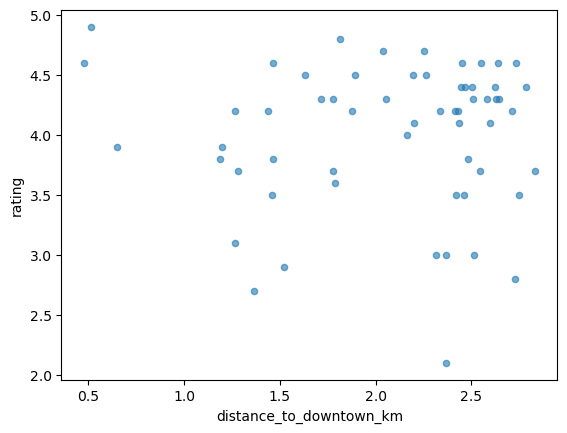

In [282]:
df.plot.scatter(
    x="distance_to_downtown_km",
    y="rating",
    alpha=0.6
)


In [283]:
# Create bins to bin restaraunts by distance from downtown
df["distance_band"] = pd.cut(
    df["distance_to_downtown_km"],
    bins=[0, 0.5, 1, 1.5, 2, 3],
    labels=["0-0.5km", "0.5-1km", "1-1.5km", "1.5-2km", "2-3km"]
)


In [284]:
# Group by bin and rating
df.groupby("distance_band")["rating"].mean()




C:\Users\brand\AppData\Local\Temp\ipykernel_2668\1725469197.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("distance_band")["rating"].mean()


distance_band
0-0.5km    4.600000
0.5-1km    4.400000
1-1.5km    3.750000
1.5-2km    4.088889
2-3km      4.027027
Name: rating, dtype: float64

In [285]:
# Checking Counts per band
df.groupby("distance_band")["rating"].agg(["count", "mean"])



C:\Users\brand\AppData\Local\Temp\ipykernel_2668\3670093058.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("distance_band")["rating"].agg(["count", "mean"])


,count,mean
distance_band,,
0-0.5km,1,4.600000
0.5-1km,2,4.400000
1-1.5km,10,3.750000
1.5-2km,9,4.088889
2-3km,37,4.027027


In [286]:
# Downtown_cinci = " 39.095, -84.514"
# Downtown_hamilton = "39.399, -84.559"
# Downtown_westchester = " 39.335, -84.404"

In [304]:
import pandas as pd

df1 = pd.read_csv("places_restaurants_CincinnatiOH.csv")
df2 = pd.read_csv("places_restaurants_hamiltonOH.csv")
df3 = pd.read_csv("places_restaurants_WestchesterOH.csv")


In [305]:
for i, df in enumerate([df1, df2, df3], start=1):
    print(f"DF{i} shape:", df.shape)
    print(df.head(2))


DF1 shape: (60, 26)
  business_status                                               icon  \
0     OPERATIONAL  https://maps.gstatic.com/mapfiles/place_api/ic...   
1     OPERATIONAL  https://maps.gstatic.com/mapfiles/place_api/ic...   

  icon_background_color                                 icon_mask_base_uri  \
0               #FF9E67  https://maps.gstatic.com/mapfiles/place_api/ic...   
1               #4B96F3  https://maps.gstatic.com/mapfiles/place_api/ic...   

  international_phone_number                   name  \
0            +1 859-491-7200  Hofbräuhaus - Newport   
1            +1 859-291-0550   Newport on the Levee   

                                              photos  \
0  [{'height': 2403, 'html_attributions': ['<a hr...   
1  [{'height': 561, 'html_attributions': ['<a hre...   

                      place_id  price_level  rating  ...  \
0  ChIJI86THG-xQYgRejQQ5jfFn-8          2.0     4.5  ...   
1  ChIJj5FhLG-xQYgRNhr-7ontbKo          NaN     4.5  ...   

  geometry.l

In [306]:
combined_df = pd.concat([df1, df2, df3], ignore_index=True)

combined_df.head()


,business_status,icon,icon_background_color,icon_mask_base_uri,international_phone_number,name,photos,place_id,price_level,rating,...,geometry.location.lng,geometry.viewport.northeast.lat,geometry.viewport.northeast.lng,geometry.viewport.southwest.lat,geometry.viewport.southwest.lng,opening_hours.open_now,plus_code.compound_code,plus_code.global_code,permanently_closed,distance_to_downtown_km
0,OPERATIONAL,https://maps.gstatic.com/mapfiles/place_api/ic...,#FF9E67,https://maps.gstatic.com/mapfiles/place_api/ic...,+1 859-491-7200,Hofbräuhaus - Newport,"[{'height': 2403, 'html_attributions': ['<a hr...",ChIJI86THG-xQYgRejQQ5jfFn-8,2.0,4.5,...,-84.493806,39.096524,-84.492639,39.093826,-84.495337,True,"3GW4+2F Newport, KY, USA",86FQ3GW4+2F,NaN,1.742718
1,OPERATIONAL,https://maps.gstatic.com/mapfiles/place_api/ic...,#4B96F3,https://maps.gstatic.com/mapfiles/place_api/ic...,+1 859-291-0550,Newport on the Levee,"[{'height': 561, 'html_attributions': ['<a hre...",ChIJj5FhLG-xQYgRNhr-7ontbKo,NaN,4.5,...,-84.496055,39.096230,-84.495217,39.093532,-84.497915,True,"3GW3+3H Newport, KY, USA",86FQ3GW3+3H,NaN,1.548775
2,OPERATIONAL,https://maps.gstatic.com/mapfiles/place_api/ic...,#FF9E67,https://maps.gstatic.com/mapfiles/place_api/ic...,+1 513-564-9111,Nicholson's Fine Food & Whiskey,"[{'height': 2701, 'html_attributions': ['<a hr...",ChIJt-5Dq1CxQYgRdum1akpW7h8,2.0,4.4,...,-84.512019,39.104703,-84.510593,39.102005,-84.513291,True,"4F3Q+85 Cincinnati, OH, USA",86FQ4F3Q+85,NaN,0.942510
3,OPERATIONAL,https://maps.gstatic.com/mapfiles/place_api/ic...,#FF9E67,https://maps.gstatic.com/mapfiles/place_api/ic...,+1 513-721-7427,Montgomery Inn The Boathouse,"[{'height': 1440, 'html_attributions': ['<a hr...",ChIJ1YpO6mOxQYgRavAlyMV6XLo,2.0,4.4,...,-84.494701,39.105607,-84.493230,39.102909,-84.495928,True,"4G34+H4 Cincinnati, OH, USA",86FQ4G34+H4,NaN,1.940776
4,OPERATIONAL,https://maps.gstatic.com/mapfiles/place_api/ic...,#FF9E67,https://maps.gstatic.com/mapfiles/place_api/ic...,+1 513-721-6232,Nada,"[{'height': 2000, 'html_attributions': ['<a hr...",ChIJ9UWCBlqxQYgRoH9ooQSY_jI,2.0,4.4,...,-84.511363,39.104241,-84.510208,39.101543,-84.512906,True,"4F3Q+5F Cincinnati, OH, USA",86FQ4F3Q+5F,NaN,0.907340


In [307]:
combined_df.info()
len(combined_df)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   business_status                  180 non-null    object 
 1   icon                             180 non-null    object 
 2   icon_background_color            180 non-null    object 
 3   icon_mask_base_uri               180 non-null    object 
 4   international_phone_number       177 non-null    object 
 5   name                             180 non-null    object 
 6   photos                           178 non-null    object 
 7   place_id                         180 non-null    object 
 8   price_level                      149 non-null    float64
 9   rating                           178 non-null    float64
 10  reference                        180 non-null    object 
 11  scope                            180 non-null    object 
 12  types                 

180

In [308]:
combined_df.shape

(180, 26)

In [309]:
combined_df.columns

Index(['business_status', 'icon', 'icon_background_color',
       'icon_mask_base_uri', 'international_phone_number', 'name', 'photos',
       'place_id', 'price_level', 'rating', 'reference', 'scope', 'types',
       'user_ratings_total', 'vicinity', 'geometry.location.lat',
       'geometry.location.lng', 'geometry.viewport.northeast.lat',
       'geometry.viewport.northeast.lng', 'geometry.viewport.southwest.lat',
       'geometry.viewport.southwest.lng', 'opening_hours.open_now',
       'plus_code.compound_code', 'plus_code.global_code',
       'permanently_closed', 'distance_to_downtown_km'],
      dtype='object')

In [310]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   business_status                  180 non-null    object 
 1   icon                             180 non-null    object 
 2   icon_background_color            180 non-null    object 
 3   icon_mask_base_uri               180 non-null    object 
 4   international_phone_number       177 non-null    object 
 5   name                             180 non-null    object 
 6   photos                           178 non-null    object 
 7   place_id                         180 non-null    object 
 8   price_level                      149 non-null    float64
 9   rating                           178 non-null    float64
 10  reference                        180 non-null    object 
 11  scope                            180 non-null    object 
 12  types                 

In [312]:
combined_df.to_csv('combined_df.csv')